***Задание. Реализовать классификацию изображений на своем датасете.***

1. Выберите датасет для классификации изображений https://pytorch.org/vision/stable/datasets.html
2. Определите архитектуру нейросети и приведите ее описание (текстом или иным способом) в своей работе
3. Реализуйте выбранную архитектуру в виде класса
4. Обучите нейросеть
5. Постройте на одном графике кривые изменения функции потерь на тесте и обучении
6. Постройте график изменения выбранной метрики качества на тесте
7. Сохраните в файл одно изображение из тестовой выборки
8. Сохраните обученную нейросеть в файл
9. Загрузите изображение из файла
10. Загрузите нейросеть
11. Выполните предсказание с помощью загруженной из файла нейросети и оцените его правильность

Для работы был выбран датасет [Country211](https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.Country211.html#torchvision.datasets.Country211)

In [ ]:
import torch
import random
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import random_split, Subset

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
    ])

In [ ]:
# Загружаем все сплиты
splits = ['train', 'valid', 'test']
datasets = {}

for split in splits:
    datasets[split] = torchvision.datasets.Country211(
        root='./data',
        split=split,
        transform=transform,
        download=True
    )
    print(f"{split}: {len(datasets[split])} изображений")

train: 31650 изображений
valid: 10550 изображений
test: 21100 изображений


Input: RGB изображение 224×224×3
    
    ├── Блок 1 (Feature Extraction)
    │   ├── Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
    │   ├── BatchNorm2d(64)
    │   ├── ReLU()
    │   ├── MaxPool2d(kernel_size=3, stride=2, padding=1)
    │
    ├── Блок 2 (Feature Learning)
    │   ├── Conv2d(64, 128, kernel_size=3, padding=1)
    │   ├── BatchNorm2d(128)
    │   ├── ReLU()
    │   ├── MaxPool2d(kernel_size=2)
    │
    ├── Блок 3 (Feature Learning)
    │   ├── Conv2d(128, 256, kernel_size=3, padding=1)
    │   ├── BatchNorm2d(256)
    │   ├── ReLU()
    │   ├── MaxPool2d(kernel_size=2)
    │
    ├── Блок 4 (Feature Learning)
    │   ├── Conv2d(256, 512, kernel_size=3, padding=1)
    │   ├── BatchNorm2d(512)
    │   ├── ReLU()
    │   ├── MaxPool2d(kernel_size=2)
    │
    ├── Global Average Pooling
    │   ├── AdaptiveAvgPool2d(1)
    │
    ├── Классификатор
    │   ├── Linear(512, 256) + ReLU() + Dropout(0.5)
    │   ├── Linear(256, 128) + ReLU() + Dropout(0.3)
    │   └── Linear(128, 211)  # 211 стран
    │
    └── Output: 211 классов (вероятности для каждой страны)

**Характеристики архитектуры:**

Тип: Сверточная нейронная сеть (CNN)

Вход: Изображения 224×224×3

Выход: 211 классов (страны)

Глубина: 4 сверточных блока + 3 полносвязных слоя

Регуляризация: Batch Normalization, Dropout

Активации: ReLU

Пулинг: Max Pooling + Global Average Pooling

In [ ]:
# Создаем подмножество тренировочных данных (20% от тренировочного набора)
subset_size = int(0.2 * len(datasets['train']))  # Используем datasets['train']
indices = np.random.choice(len(datasets['train']), size=subset_size, replace=False)
subset_train_data = torch.utils.data.Subset(datasets['train'], indices)

# Разделяем подмножество на тренировочную и валидационную части
val_size = int(0.2 * len(subset_train_data))
train_size = len(subset_train_data) - val_size
train_data, val_data = torch.utils.data.random_split(subset_train_data, [train_size, val_size])

# Используем оригинальный test набор
test_size = len(datasets['test'])
full_test_data = datasets['test']

In [ ]:
# Создаем тестовое подмножество такого же размера как val_data
test_size = len(val_data)
test_indices = np.random.choice(len(full_test_data), size=test_size, replace=False)

# Создаем тестовое множество на основе выбранных индексов
test_data = torch.utils.data.Subset(full_test_data, test_indices)

# Теперь у вас есть train_data, val_data и test_data
print(f'Train data size: {len(train_data)}')
print(f'Validation data size: {len(val_data)}')
print(f'Test data size: {len(test_data)}')

Train data size: 5064
Validation data size: 1266
Test data size: 1266


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

In [ ]:
X_test, y_test = next(iter(test_dataloader))

In [ ]:
X_train, y_train = next(iter(train_dataloader))
print(f"Feature batch shape: {X_train.size()}")
print(f"Labels batch shape: {y_train.size()}")

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


In [ ]:
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=211):
        super(SimpleCNN, self).__init__()
        self.features = torch.nn.Sequential(
            # 224x224x3 -> 112x112x64
            torch.nn.Conv2d(3, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            # 112x112x64 -> 56x56x128
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            # 56x56x128 -> 28x28x256
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),

            # 28x28x256 -> 14x14x512
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((7, 7)),
            torch.nn.Flatten(),
            torch.nn.Linear(512 * 7 * 7, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

simple_cnn = SimpleCNN(num_classes=211)

# Проверяем модель
print(simple_cnn)

# Тестовый forward pass с размером как в Country211 (обычно 224x224)
test_input = torch.randn(4, 3, 224, 224)
output = simple_cnn(test_input)
print(f"Входной размер: {test_input.shape}")
print(f"Выходной размер: {output.shape}")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
simple_cnn = simple_cnn.to(device)
print(f"Устройство: {device}")

Устройство: cpu


In [ ]:
optimizer = torch.optim.Adam(simple_cnn.parameters(), lr=1.0e-3)

In [ ]:
loss = torch.nn.CrossEntropyLoss()

In [15]:
# изменения при оптимизации на тестовой выборке
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

for epoch in range(5):
    # Обучение
    epoch_train_loss = 0.0
    simple_cnn.train()

    for X, y in train_dataloader:
        # обязательно обнуляем градиенты
        optimizer.zero_grad()

        X_batch = X.to(device)
        y_batch = y.to(device)

        # делаем предсказание
        preds = simple_cnn(X_batch)

        # считаем лосс значение
        loss_value = loss(preds, y_batch)

        # берем градиенты
        loss_value.backward()

        # и пусть оптимайзер все оптимизирует
        optimizer.step()

        epoch_train_loss += loss_value.item()

    # Сохраняем средний лосс за эпоху
    train_loss_history.append(epoch_train_loss / len(train_dataloader))

    # Тестирование
    simple_cnn.eval()
    epoch_test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in test_dataloader:
            X_batch = X.to(device)
            y_batch = y.to(device)

            test_preds = simple_cnn(X_batch)
            loss_test = loss(test_preds, y_batch)
            epoch_test_loss += loss_test.item()

            # Считаем accuracy
            _, predicted = test_preds.max(1)
            total += y_batch.size(0)
            correct += predicted.eq(y_batch).sum().item()

    test_loss_history.append(epoch_test_loss / len(test_dataloader))
    accuracy = 100. * correct / total
    test_accuracy_history.append(accuracy)

    print(f"Epoch {epoch+1}/5 - Train Loss: {train_loss_history[-1]:.4f}, "
          f"Test Loss: {test_loss_history[-1]:.4f}, "
          f"Test Accuracy: {accuracy:.2f}%")

print("Обучение SimpleCNN завершено!")

Epoch 1/5 - Train Loss: 6.1201, Test Loss: 5.3500, Test Accuracy: 0.71%
Epoch 2/5 - Train Loss: 5.3511, Test Loss: 5.3516, Test Accuracy: 0.63%
Epoch 3/5 - Train Loss: 5.3492, Test Loss: 5.3517, Test Accuracy: 0.47%
Epoch 4/5 - Train Loss: 5.3468, Test Loss: 5.3520, Test Accuracy: 0.47%
Epoch 5/5 - Train Loss: 5.3465, Test Loss: 5.3526, Test Accuracy: 0.47%
Обучение SimpleCNN завершено!


In [16]:
import matplotlib.pyplot as plt

/tmp/ipython-input-3330881870.py:1: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


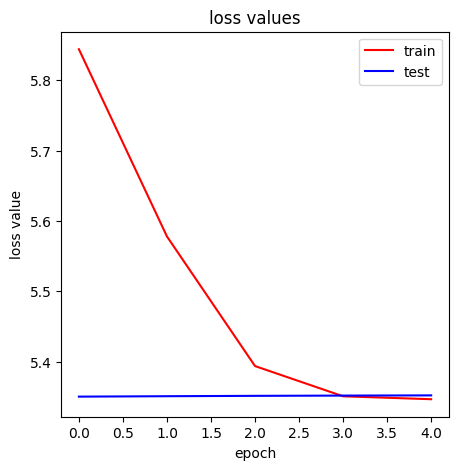

In [51]:
from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'epoch',
       ylabel = 'loss value')
train_loss_smoothed = gaussian_filter1d(train_loss_history, sigma=1)
ax.plot(train_loss_smoothed, color='red',  label='train')

test_loss_smoothed = gaussian_filter1d(test_loss_history, sigma=1)
ax.plot(test_loss_smoothed, color='blue',  label='test')
ax.legend()
plt.show()

/tmp/ipython-input-640516755.py:1: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


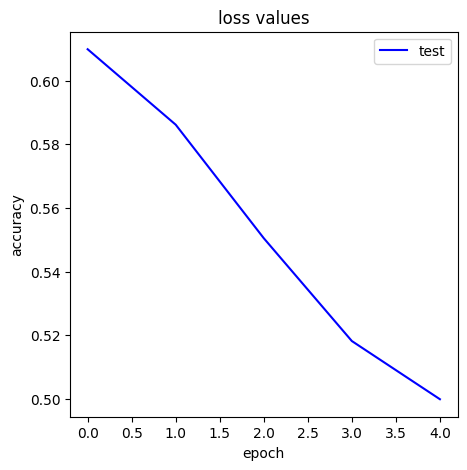

In [31]:
from scipy.ndimage.filters import gaussian_filter1d
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111)
ax.set(title = 'loss values',
       xlabel = 'epoch',
       ylabel = 'accuracy')
test_accuracy_smoothed = gaussian_filter1d(test_accuracy_history, sigma=2)
ax.plot(test_accuracy_smoothed, color='blue',  label='test')

ax.legend()
plt.show()


In [19]:
timg = X_test[7]

torch.save(timg,'tensor.pt')

In [20]:
y_test[7]

tensor(92)

In [21]:
timg.size()

torch.Size([3, 224, 224])

In [24]:
X_test.size()

torch.Size([16, 3, 224, 224])

In [25]:
!pip install dill

In [34]:
import dill

with open("model.dill", "wb") as dill_file:
    dill.dump(simple_cnn, dill_file)

In [35]:
ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

test_data = torch.load('tensor.pt')

In [36]:
type(modelp)

__main__.SimpleCNN

In [37]:
test_data.shape

torch.Size([3, 224, 224])

In [38]:
test_data = test_data.data.cpu()

In [39]:

t_data = torch.tensor([test_data.numpy()])

/tmp/ipython-input-1363442101.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  t_data = torch.tensor([test_data.numpy()])


In [40]:
t_data.shape

torch.Size([1, 3, 224, 224])

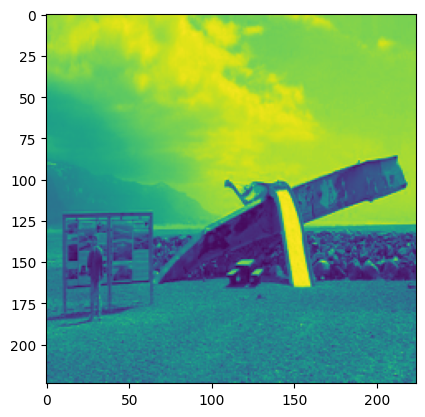

In [41]:
plt.imshow(test_data[0, :, :])
plt.show()

In [42]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

modelp.to(dev)
model_data = modelp.to(dev)

t_data = t_data.to(dev)

In [43]:
preds = modelp.forward(t_data)

In [44]:
print(preds)

tensor([[-1.2247e-01,  4.6397e-02, -4.4298e-02, -1.1968e-01, -2.2235e-02,
          8.9627e-03, -6.4650e-02, -9.0416e-03,  1.9961e-02, -4.3966e-02,
          2.6169e-02,  6.3302e-02, -5.7079e-02, -9.0541e-02,  1.3976e-02,
          2.6705e-02, -1.7551e-02,  2.0828e-02, -1.0748e-01, -3.6663e-02,
          6.0931e-02, -1.8201e-01,  8.6516e-02, -1.8134e-01, -1.0820e-01,
         -8.4663e-02, -3.9924e-02, -1.6420e-02, -2.0763e-02, -6.7118e-02,
         -3.3823e-03,  2.8378e-02,  9.1340e-02, -7.9609e-03,  4.4557e-02,
          4.5902e-02, -3.8155e-02, -9.6037e-02,  3.5018e-03,  5.9538e-02,
         -2.0684e-02,  1.0997e-01, -1.1297e-01,  2.3186e-02, -3.2235e-02,
         -2.2429e-02, -4.9996e-03, -1.0960e-02, -3.6653e-02,  1.9466e-02,
         -6.6676e-02,  4.2045e-03, -1.1881e-01,  5.8383e-02, -1.6811e-02,
          7.1144e-02, -6.1675e-02, -1.1041e-01, -6.8678e-02,  3.2475e-02,
         -4.3123e-02,  3.1843e-03, -4.1202e-02, -8.6259e-02,  2.9592e-02,
         -4.1646e-02, -6.9468e-02, -6.

In [45]:
prediction = np.argmin(preds.to('cpu').detach().numpy(),axis=-1)

In [46]:
print(prediction)

[115]


In [50]:
val_data1 = torchvision.datasets.Country211('./', split='test', transform=transform, download=True)

100%|██████████| 11.0G/11.0G [02:29<00:00, 73.5MB/s]


In [52]:
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
X_val, y_val = next(iter(val_dataloader))

In [53]:
timg1 = X_val[60]

torch.save(timg1,'tensor.pt')

In [54]:
y_val[60]

tensor(99)

In [56]:
with open("model.dill", "wb") as dill_file:
    dill.dump(simple_cnn, dill_file)

In [58]:
ifile = open("model.dill", "rb")
modelp = dill.load(ifile)
ifile.close()

val_data = torch.load('tensor.pt')

In [59]:
val_data.shape

torch.Size([3, 224, 224])

In [60]:
val_data = val_data.data.cpu()

In [61]:
v_data = torch.tensor([val_data.numpy()])

In [62]:
v_data.shape

torch.Size([1, 3, 224, 224])

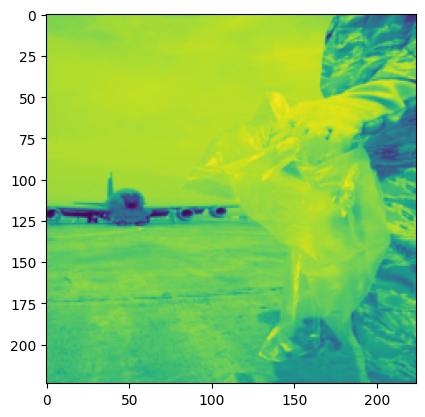

In [63]:
plt.imshow(val_data[0, :, :])
plt.show()

In [64]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

modelp.to(dev)
model_data = modelp.to(dev)

v_data = v_data.to(dev)

In [65]:
preds = modelp.forward(v_data)

In [66]:
print(preds)

tensor([[-1.2247e-01,  4.6397e-02, -4.4298e-02, -1.1968e-01, -2.2235e-02,
          8.9627e-03, -6.4650e-02, -9.0416e-03,  1.9961e-02, -4.3966e-02,
          2.6169e-02,  6.3302e-02, -5.7079e-02, -9.0541e-02,  1.3976e-02,
          2.6705e-02, -1.7551e-02,  2.0828e-02, -1.0748e-01, -3.6663e-02,
          6.0931e-02, -1.8201e-01,  8.6516e-02, -1.8134e-01, -1.0820e-01,
         -8.4663e-02, -3.9924e-02, -1.6420e-02, -2.0763e-02, -6.7118e-02,
         -3.3823e-03,  2.8378e-02,  9.1340e-02, -7.9609e-03,  4.4557e-02,
          4.5902e-02, -3.8155e-02, -9.6037e-02,  3.5018e-03,  5.9538e-02,
         -2.0684e-02,  1.0997e-01, -1.1297e-01,  2.3186e-02, -3.2235e-02,
         -2.2429e-02, -4.9996e-03, -1.0960e-02, -3.6653e-02,  1.9466e-02,
         -6.6676e-02,  4.2045e-03, -1.1881e-01,  5.8383e-02, -1.6811e-02,
          7.1144e-02, -6.1675e-02, -1.1041e-01, -6.8678e-02,  3.2475e-02,
         -4.3123e-02,  3.1843e-03, -4.1202e-02, -8.6259e-02,  2.9592e-02,
         -4.1646e-02, -6.9468e-02, -6.

In [67]:
prediction = np.argmin(preds.to('cpu').detach().numpy(),axis=-1)


In [68]:
print(prediction)

[115]
